# PCA-SVM

Notebook utilizado para treinamento dos modelos de Jogo Completo, 1° Tempo e 2° Tempo utilizando a arquitetura PCA-SVM

## Importação dos dados

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from numpy.ma.core import correlate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data=pd.read_csv('https://raw.githubusercontent.com/pvesouza/datasets/main/Dataset_1.csv')
print(data.shape)
data.head()

(5796, 19)


,time,league,pitch,weather,score_home,score_away,corners_home,corners_away,on_target_home,on_target_away,off_target_home,off_target_away,dang_attacks_home,dang_attacks_away,attacks_home,attacks_away,possession_home,possession_away,target
0,fh,Israel Youth League,GOOD,GOOD,0,1,2,1,1,1,0,0,62,31,119,72,65%,35%,False
1,lh,Israel Youth League,GOOD,GOOD,1,1,6,2,0,1,0,0,28,14,60,40,64%,36%,True
2,fh,Mali Premiere Division,GOOD,GOOD,0,0,1,3,9,4,12,18,78,57,142,127,51%,49%,False
3,lh,Mali Premiere Division,GOOD,GOOD,0,0,4,3,6,1,10,9,35,30,71,63,50%,50%,False
4,fh,Tanzania Premier Le...,GOOD,GOOD,1,0,7,0,9,4,12,2,83,44,103,87,61%,39%,False


In [ ]:
#Observando as frequências do das classes
#cpy_dataSet.drop(columns=['pitch', 'weather', 'league'], inplace=True)
data.drop(columns=['pitch', 'weather', 'league'], inplace=True)
data.describe()

,score_home,score_away,corners_home,corners_away,on_target_home,on_target_away,off_target_home,off_target_away,dang_attacks_home,dang_attacks_away,attacks_home,attacks_away
count,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000
mean,1.086266,0.933230,2.427019,2.124396,3.500518,2.991373,4.858523,4.328675,41.179434,37.679434,73.042098,70.048482
std,1.247110,1.181038,1.867396,1.786601,2.838142,2.542802,3.590083,3.366097,22.599936,21.264838,32.465153,30.961395
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,24.000000,22.000000,47.000000,45.000000
50%,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,4.000000,4.000000,36.000000,33.000000,67.000000,64.000000
75%,2.000000,1.000000,3.000000,3.000000,5.000000,4.000000,7.000000,6.000000,54.000000,49.000000,96.000000,92.000000
max,12.000000,12.000000,14.000000,13.000000,23.000000,22.000000,26.000000,25.000000,162.000000,157.000000,238.000000,209.000000


In [ ]:
#descrição mais precisa do dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   time               5796 non-null   object
 1   score_home         5796 non-null   int64 
 2   score_away         5796 non-null   int64 
 3   corners_home       5796 non-null   int64 
 4   corners_away       5796 non-null   int64 
 5   on_target_home     5796 non-null   int64 
 6   on_target_away     5796 non-null   int64 
 7   off_target_home    5796 non-null   int64 
 8   off_target_away    5796 non-null   int64 
 9   dang_attacks_home  5796 non-null   int64 
 10  dang_attacks_away  5796 non-null   int64 
 11  attacks_home       5796 non-null   int64 
 12  attacks_away       5796 non-null   int64 
 13  possession_home    5796 non-null   object
 14  possession_away    5796 non-null   object
 15  target             5796 non-null   bool  
dtypes: bool(1), int64(12), object(3)
memory us

## Pré-processamento dos dados

In [ ]:
def contains(str, c):
  for i in str:
    if i == '%':
      return True
  return False

In [ ]:
#Operacionalizando as colunas possession_home e possession_away para mostrarem a porcentarem em termos de float
p_home = data['possession_home']
p_away = data['possession_away']

indexes = []
last_to_drop = 0

for index in range(0, len(p_home)):
  #Convertendo tudo para o tipo string
  value_ = str(p_home[index])
  teste = contains(value_, '%')
  if teste == False:
    if (last_to_drop != index):
      indexes.append(index)
      last_to_drop = index

  value_ = str(p_away[index])
  teste = contains(value_, '%')

  if teste == False:
    if (last_to_drop != index):
      indexes.append(index)
      last_to_drop = index

print(indexes)


[]


In [ ]:
#Drops the index of the dataset
newdf = data
if len(indexes) != 0:
  newdf = data.drop(indexes, axis=0)

p_home = newdf['possession_home'].values
p_away = newdf['possession_away'].values

p_home_transformed = np.zeros(shape = p_home.shape)
p_away_transformed = np.zeros(shape = p_away.shape)

index = 0
for _str in p_home:
  str_value = _str
  val = ''
  for c in str_value:
    if (c != '%'):
      val = val + c
  p_home_transformed[index] = float(val) / 100
  index += 1

index = 0
for _str in p_away:
  str_value = _str
  val = ''
  for c in str_value:
    if (c != '%'):
      val = val + c
  p_away_transformed[index] = float(val) / 100
  index += 1

print(p_home_transformed[0])
print(p_away_transformed[0])

0.65
0.35


In [ ]:
newdf['possession_home'] = p_away_transformed
newdf['possession_away'] = p_home_transformed

newdf['time'].replace({'fh': 1, 'lh': 2}, inplace=True)

newdf.describe()

,time,score_home,score_away,corners_home,corners_away,on_target_home,on_target_away,off_target_home,off_target_away,dang_attacks_home,dang_attacks_away,attacks_home,attacks_away,possession_home,possession_away
count,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000,5796.000000
mean,1.500000,1.086266,0.933230,2.427019,2.124396,3.500518,2.991373,4.858523,4.328675,41.179434,37.679434,73.042098,70.048482,0.488194,0.511806
std,0.500043,1.247110,1.181038,1.867396,1.786601,2.838142,2.542802,3.590083,3.366097,22.599936,21.264838,32.465153,30.961395,0.091339,0.091339
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.190000,0.150000
25%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,24.000000,22.000000,47.000000,45.000000,0.430000,0.450000
50%,1.500000,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,4.000000,4.000000,36.000000,33.000000,67.000000,64.000000,0.490000,0.510000
75%,2.000000,2.000000,1.000000,3.000000,3.000000,5.000000,4.000000,7.000000,6.000000,54.000000,49.000000,96.000000,92.000000,0.550000,0.570000
max,2.000000,12.000000,12.000000,14.000000,13.000000,23.000000,22.000000,26.000000,25.000000,162.000000,157.000000,238.000000,209.000000,0.850000,0.810000


In [ ]:
#Adicionando a diferença de gols entre os times
score_home = newdf['score_home'].values - newdf['score_away'].values
newdf['diff_scores'] = score_home

#Adicionando a soma dos corners
total_corners = newdf['corners_home'].values + newdf['corners_away'].values
newdf['total_corners'] = total_corners

#Adicionando a soma dos chutes no alvo
total_on_target_kicks = newdf['on_target_home'].values + newdf['on_target_away'].values
newdf['total_on_target_kicks'] = total_on_target_kicks

#Adicionando a diferença de ataques perigosos
diff_dang_attacks = newdf['dang_attacks_home'].values - newdf['dang_attacks_away'].values
newdf['diff_on_dang_attacks'] = diff_dang_attacks

#Adicionando a diferença nos ataques
diff_attacks = newdf['attacks_home'].values - newdf['attacks_away'].values
newdf['diff_on_attacks'] = diff_attacks

#Adicionando a diferença na posse de bola
diff_possession = newdf['possession_home'].values - newdf['possession_away'].values
newdf['diff_on_possession'] = diff_possession

In [ ]:
newdf.columns

Index(['score_home', 'score_away', 'corners_home', 'corners_away',
       'on_target_home', 'on_target_away', 'off_target_home',
       'off_target_away', 'dang_attacks_home', 'dang_attacks_away',
       'attacks_home', 'attacks_away', 'target', 'Possession_away_t',
       'Possession_home_t', 'diff_scores', 'total_on_target_kicks',
       'diff_on_dang_attacks', 'diff_on_attacks', 'diff_on_possession'],
      dtype='object')

In [ ]:
def plot_corr(df): 

  figure = plt.figure(figsize=(20,15))
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  ax = sns.heatmap(corr,mask = mask, annot = True, cmap='coolwarm')
  ax.set_title('Correlação entre as variáveis')
  plt.show()

## Jogo Completo

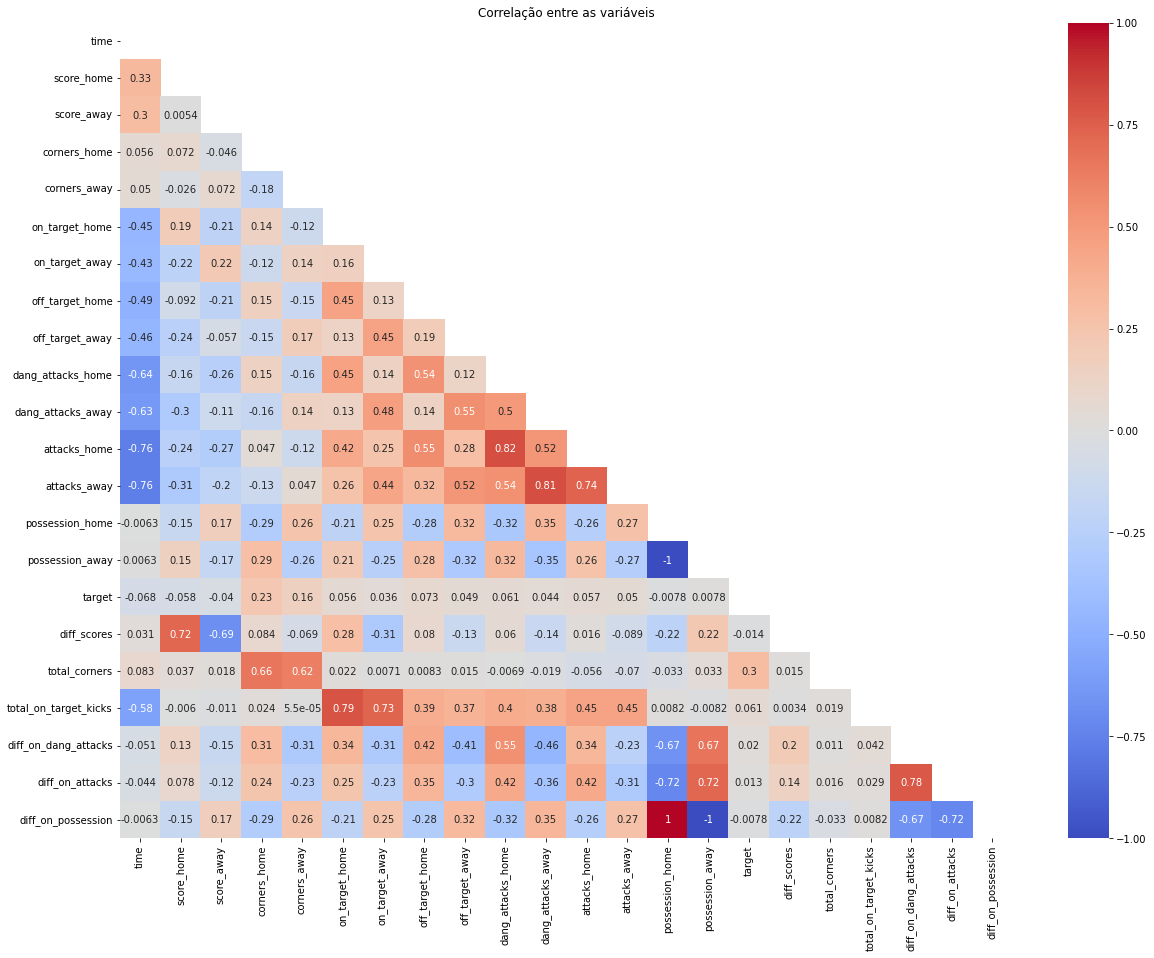

In [ ]:
plot_corr(newdf)

In [ ]:
X = newdf.drop(columns = ['target'])
y = newdf['target']

y.value_counts()

False    2936
True     2860
Name: target, dtype: int64

In [ ]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4636, 21)
(1160, 21)
(4636,)
(1160,)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
pca = PCA(random_state=10, n_components=0.95)
svc = SVC(random_state=10)

model = Pipeline(steps = [('scaler', scaler), ('pca', pca),('model', svc)])

In [ ]:
svc = SVC()
# defining parameter range for svm
param_grid = {'model__C': [0.1, 1, 10,],
              'model__gamma': [1, 0.1, 0.01, 0.001],
              'model__kernel': ['poly', 'rbf', 'sigmoid']}

# define random search for SVM
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=5, random_state=10)
search = RandomizedSearchCV(model, param_grid, n_iter=15, scoring='precision', n_jobs=-1, cv=cv, random_state=10)

# execute search
result_svc = search.fit(X_train, y_train)

# summarize result for SVM
print('=========Random Search Results for SVM==========')
print('Best Score: %s' % result_svc.best_score_)
print('Best Hyperparameters: %s' % result_svc.best_params_)


=========Random Search Results for SVM==========
Best Score: 0.6466352022180554
Best Hyperparameters: {'model__kernel': 'sigmoid', 'model__gamma': 0.01, 'model__C': 10}


In [ ]:
# Imprimindo o classification report
modelo = result_svc.best_estimator_
print (classification_report(y_test, modelo.predict(X_test)))

print (confusion_matrix(y_test, modelo.predict(X_test)))

              precision    recall  f1-score   support

       False       0.63      0.67      0.65       602
        True       0.62      0.58      0.60       558

    accuracy                           0.63      1160
   macro avg       0.63      0.62      0.62      1160
weighted avg       0.63      0.63      0.62      1160

[[404 198]
 [236 322]]


## 1° Tempo

In [ ]:
df_1half = newdf[newdf.time == 1]
df_1half

,time,score_home,score_away,corners_home,corners_away,on_target_home,on_target_away,off_target_home,off_target_away,dang_attacks_home,...,attacks_away,possession_home,possession_away,target,diff_scores,total_corners,total_on_target_kicks,diff_on_dang_attacks,diff_on_attacks,diff_on_possession
0,1,0,1,2,1,1,1,0,0,62,...,72,0.35,0.65,False,-1,3,2,31,47,-0.30
2,1,0,0,1,3,9,4,12,18,78,...,127,0.49,0.51,False,0,4,13,21,15,-0.02
4,1,1,0,7,0,9,4,12,2,83,...,87,0.39,0.61,False,1,7,13,39,16,-0.22
6,1,0,1,1,2,1,2,1,2,64,...,94,0.51,0.49,False,-1,3,3,18,8,0.02
8,1,0,0,1,0,0,7,6,7,45,...,129,0.64,0.36,False,0,1,7,-20,-20,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5786,1,1,0,0,5,3,3,6,6,38,...,113,0.64,0.36,True,1,5,6,-26,-26,0.28
5788,1,2,0,4,3,5,2,3,6,48,...,94,0.56,0.44,True,2,7,7,-11,-21,0.12
5790,1,0,1,3,1,3,4,8,5,37,...,107,0.45,0.55,True,-1,4,7,10,-1,-0.10
5792,1,1,0,5,0,8,4,4,2,49,...,89,0.54,0.46,False,1,5,12,31,33,0.08


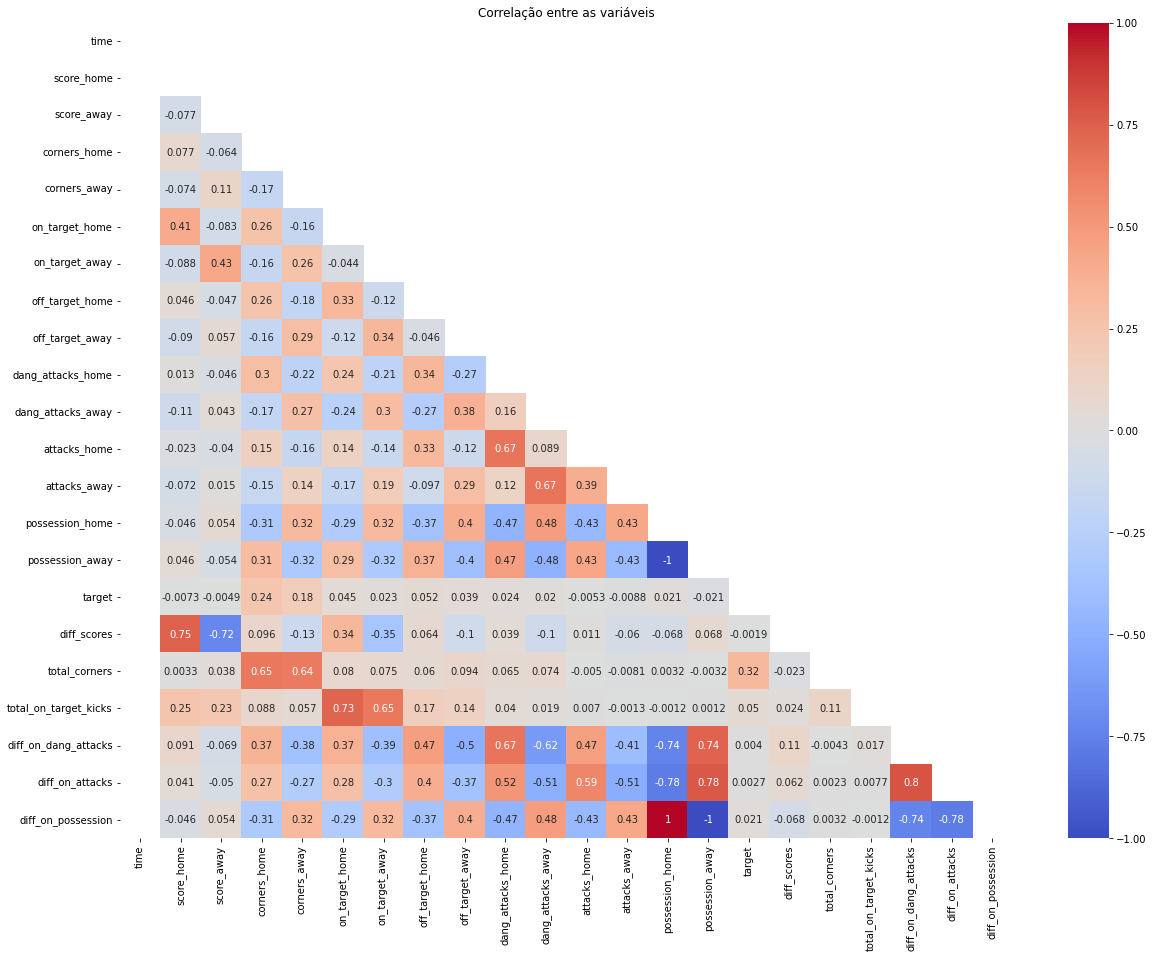

In [ ]:
plot_corr(df_1half)

In [ ]:
X = df_1half.drop(columns = ['target'])
y = df_1half['target']

y.value_counts()

True     1528
False    1370
Name: target, dtype: int64

In [ ]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2318, 21)
(580, 21)
(2318,)
(580,)


In [ ]:
# execute search
result_svc = search.fit(X_train, y_train)

# summarize result for SVM
print('=========Random Search Results for SVM==========')
print('Best Score: %s' % result_svc.best_score_)
print('Best Hyperparameters: %s' % result_svc.best_params_)

=========Random Search Results for SVM==========
Best Score: 0.6707867814573372
Best Hyperparameters: {'model__kernel': 'rbf', 'model__gamma': 0.01, 'model__C': 10}


In [ ]:
# Imprimindo o classification report
modelo = result_svc.best_estimator_
print (classification_report(y_test, modelo.predict(X_test)))

print (confusion_matrix(y_test, modelo.predict(X_test)))

              precision    recall  f1-score   support

       False       0.57      0.57      0.57       267
        True       0.63      0.63      0.63       313

    accuracy                           0.60       580
   macro avg       0.60      0.60      0.60       580
weighted avg       0.60      0.60      0.60       580

[[152 115]
 [117 196]]


## 2° Tempo

In [ ]:
df_2half = newdf[newdf.time == 2]
df_2half

,time,score_home,score_away,corners_home,corners_away,on_target_home,on_target_away,off_target_home,off_target_away,dang_attacks_home,...,attacks_away,possession_home,possession_away,target,diff_scores,total_corners,total_on_target_kicks,diff_on_dang_attacks,diff_on_attacks,diff_on_possession
1,2,1,1,6,2,0,1,0,0,28,...,40,0.36,0.64,True,0,8,1,14,20,-0.28
3,2,0,0,4,3,6,1,10,9,35,...,63,0.50,0.50,False,0,7,7,5,8,0.00
5,2,4,0,0,0,5,4,7,0,47,...,42,0.41,0.59,False,4,0,9,26,3,-0.18
7,2,0,1,0,2,0,1,1,0,22,...,39,0.55,0.45,False,-1,2,1,-1,4,0.10
9,2,0,2,0,3,0,2,2,2,23,...,73,0.64,0.36,False,-2,3,2,-5,-18,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5787,2,2,2,1,4,2,0,3,2,18,...,53,0.68,0.32,False,0,5,2,-8,-11,0.36
5789,2,2,0,0,4,4,0,3,2,35,...,46,0.54,0.46,True,2,4,4,12,-2,0.08
5791,2,1,3,1,1,2,1,4,4,19,...,54,0.49,0.51,True,-2,2,3,5,-4,-0.02
5793,2,1,1,3,0,4,1,4,1,27,...,43,0.53,0.47,True,0,3,5,18,21,0.06


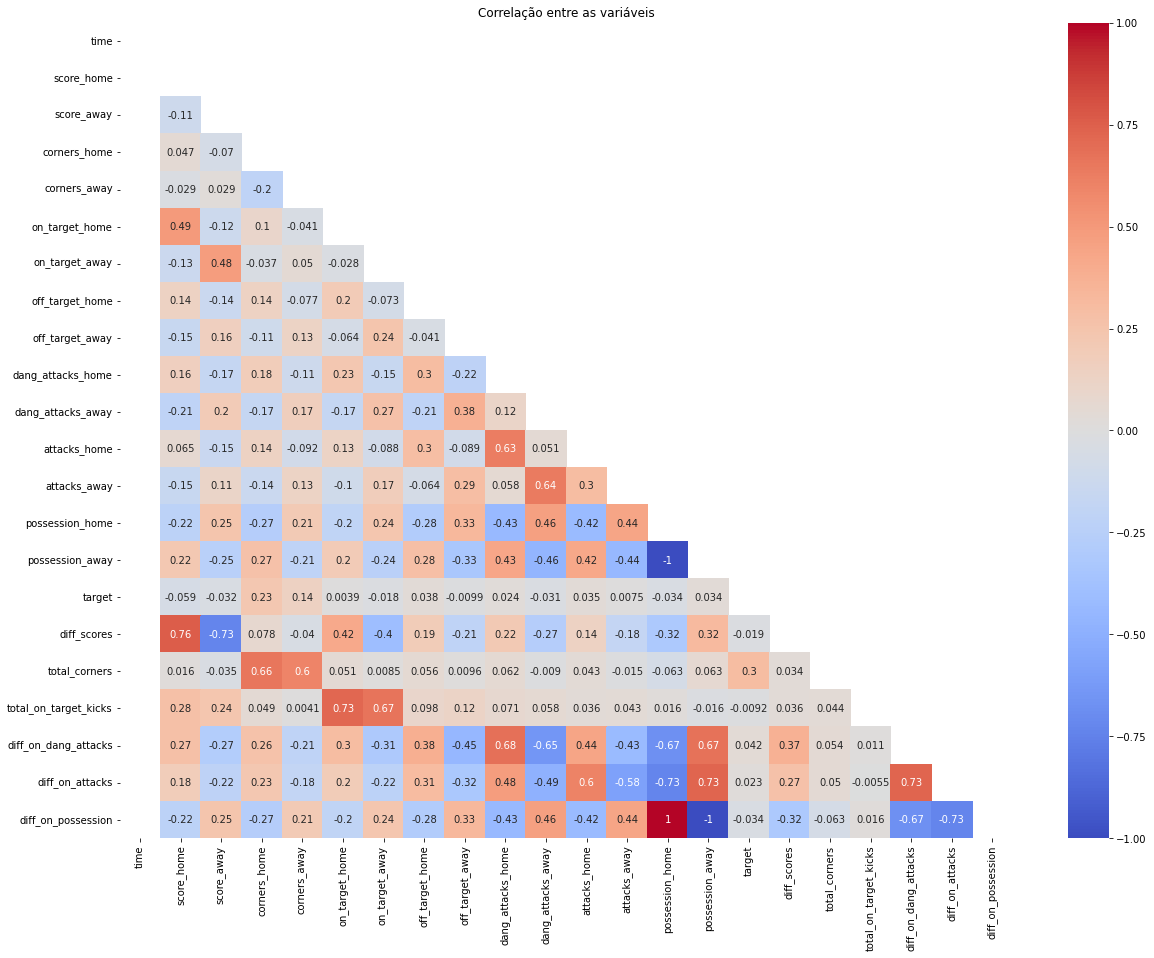

In [ ]:
plot_corr(df_2half)

In [ ]:
X = df_2half.drop(columns = ['target'])
y = df_2half['target']

y.value_counts()

False    1566
True     1332
Name: target, dtype: int64

In [ ]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2318, 21)
(580, 21)
(2318,)
(580,)


In [ ]:
# execute search
result_svc = search.fit(X_train, y_train)

# summarize result for SVM
print('=========Random Search Results for SVM==========')
print('Best Score: %s' % result_svc.best_score_)
print('Best Hyperparameters: %s' % result_svc.best_params_)

=========Random Search Results for SVM==========
Best Score: 0.6581925613790635
Best Hyperparameters: {'model__kernel': 'poly', 'model__gamma': 1, 'model__C': 1}


In [ ]:
# Imprimindo o classification report
modelo = result_svc.best_estimator_
print (classification_report(y_test, modelo.predict(X_test)))

print (confusion_matrix(y_test, modelo.predict(X_test)))

              precision    recall  f1-score   support

       False       0.59      0.96      0.73       323
        True       0.73      0.15      0.25       257

    accuracy                           0.60       580
   macro avg       0.66      0.55      0.49       580
weighted avg       0.65      0.60      0.51       580

[[309  14]
 [219  38]]
